<a href="https://colab.research.google.com/github/lungnahahd/Tensorflow_Prac/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Building an Image Classifier

필요한 Tensorflow(Feat Keras)를 설치하고, 버전을 확인하면서 알맞게 설치되었는지 확인

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__ # 텐서플로우 버전 확인

'2.8.0'

Keras에서 지원하는 mnist 데이터 셋을 다운받고, 이를 불러와서 변수에 저장

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data() # 이런 형식은 데이터 자체가 지원

4431872/4422102 [==============================] - 0s 0us/step


전체 Train 데이터 이미지는 60000 장이 존재하고, 각 이미지는 28x28 픽셀로 구성

In [5]:
X_train_full.shape # 3차원 데이터 출력됨

(60000, 28, 28)

각 픽셀은 0 ~ 255, 총 256 개의 값을 가질 수 있음
====> 그 결과 8 비트의 데이터 타입을 가지고 있음

In [6]:
X_train_full.dtype

dtype('uint8')

valid와 train 데이터를 나누어서 저장하고, x는 255.(float 타입 형성)으로 나누어주어서 feature Scaling을 진행 //
또한 test 데이터 역시 동일한 과정을 진행(단, 해당 예제는 분류 예제이므로 y는 scaling 진행 x)

In [7]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255. # 데이터를 알맞게 나누고 min-max를 사용
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255. # min-max 사용

예시 이미지를 찍어서 확인하는 것

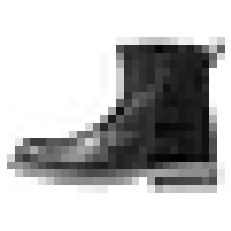

In [18]:
plt.imshow(X_train[3], cmap="binary") # cmap으로 보여줄 이미지 색깔 옵션 부여
plt.axis('off')
plt.show()

y_train 데이터를 확인

In [23]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [22]:
y_train.shape #  y_train은 단순 결과만을 출력하므로 1차원 데이터임을 주의!!

(55000,)

결과를 원하는 대로 추출하기 위해 선언한 배열

In [24]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [26]:
class_names[y_train[0]] # 첫 데이터가 맵핑되는 결과를 출력해보기

'Coat'

Validation 데이터는 5000장이 존재하고 28,28 픽셀로 되어있기에 데이터 형태 출력에 주의

In [ ]:
X_valid.shape

(5000, 28, 28)

In [29]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

In [31]:
# 사진을 저장할 경로를 지정하는 부분
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 사진 저장을 담당하는 함수
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout() # 보여지는 서브 플롯 간에 올바른 간격을 자동으로 유지
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure fashion_mnist_plot


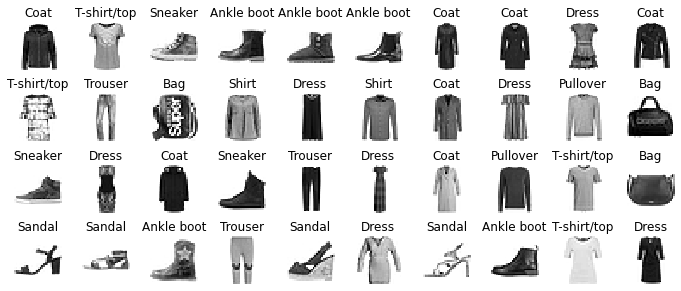

In [32]:
# 전체 이미지를 출력해서 보여주는 부분 
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

모델을 Creating 하는 부분

In [36]:
import numpy as np

초기 weight의 랜덤 값을 고정시켜서 매번 학습마다 새롭게 지정되는 것을 막음
Creating Model 전에 실행시켜 주기! 

In [35]:
keras.backend.clear_session()
np.random.seed(42) # 참고로 안에 42 숫자는 임의로 지정 가능
tf.random.set_seed(42) # 안에 42 숫자는 임의로 지정 가능

**Creating Model #1**
add 로 처리해서 모델 생성하기!!

In [33]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

**Creating Model #2** List로 넣어주기 => 수업 프린트 내용

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [37]:
model.layers # 생성한 모델의 layer들을 확인

전체 모델의 형태와 파라미터를 확인

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


전체적인 layer의 형태를 그림으로 정리

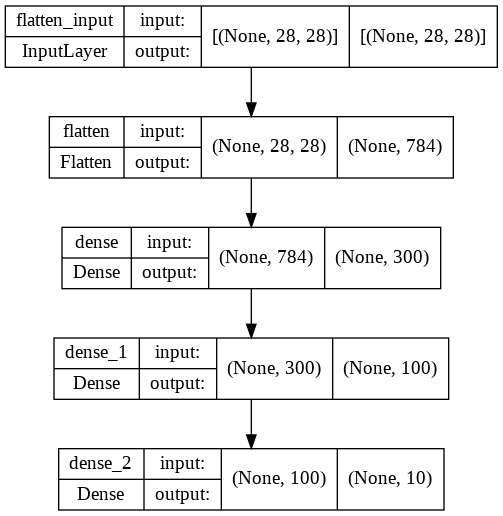

In [39]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True) # 옆에 작성한 png 이름 대로 아래의 표를 그림을 저장

In [42]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [43]:
model.get_layer(hidden1.name) is hidden1

True

**중요!!**
각 계층에서 weight와 파라미터 받는 결과 잘 확인하기!!

In [44]:
weights, biases = hidden1.get_weights()

In [45]:
weights # weights는 랜덤하게 부여!!

array([[ 0.00564697,  0.06949197,  0.06067532, ..., -0.05729853,
        -0.07381565, -0.0724486 ],
       [-0.00228447,  0.07438429, -0.03885133, ...,  0.00934017,
        -0.06915569, -0.03900045],
       [ 0.05042081, -0.064826  ,  0.01664159, ...,  0.05108191,
        -0.06462181,  0.02547596],
       ...,
       [-0.07192306,  0.06295431,  0.02985815, ..., -0.0346368 ,
         0.05090292,  0.05918679],
       [ 0.03149067,  0.01979866,  0.01781709, ..., -0.02061   ,
         0.01104549,  0.02450431],
       [-0.05164539,  0.01921857,  0.01541029, ..., -0.06215887,
         0.06442836,  0.02047986]], dtype=float32)

In [46]:
weights.shape

(784, 300)

In [47]:
biases # biases는 0으로 초기화

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [48]:
biases.shape

(300,)

위에서 Creating한 모델을 가지고 Compile 진행

In [49]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"]) 

위의 코드와 동일하게 아래처럼 작성이 가능

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

반복 학습 횟수를 30으로 주고, 실제로 모델을 학습시키고 validation도 같이 진행하는 단계(해당 단계의 결과를 history에 저장해서 추후에 활용)

In [50]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 7s 3ms/step - loss: 0.7071 - accuracy: 0.7692 - val_loss: 0.5143 - val_accuracy: 0.8244
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4862 - accuracy: 0.8288 - val_loss: 0.4341 - val_accuracy: 0.8524
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4414 - accuracy: 0.8441 - val_loss: 0.5142 - val_accuracy: 0.8070
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4146 - accuracy: 0.8548 - val_loss: 0.3956 - val_accuracy: 0.8634
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3957 - accuracy: 0.8616 - val_loss: 0.3796 - val_accuracy: 0.8684
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3770 - accuracy: 0.8677 - val_loss: 0.3720 - val_accuracy: 0.8718
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3648 - accuracy: 0.8720 - val_loss: 0.3718 - val_accuracy:

In [52]:
history.params # 위에서 저장한 학습 내용

{'epochs': 30, 'steps': 1719, 'verbose': 1}

In [53]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**중요!!**
학습 결과 변수를 바탕으로 그래프를 그리는 부분

Saving figure keras_learning_curves_plot


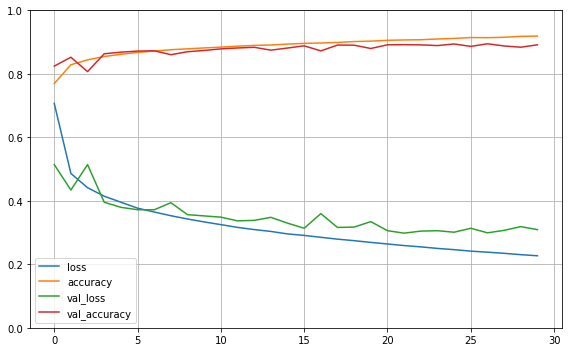

In [56]:
# pandas는 데이터를 저장하고 가공하는 데에 도움을 주는 라이브러리
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5)) # dataframe으로 데이터를 가공하고, plot()으로 해당 데이터를 활용해서 line 그래프 그리기
plt.grid(True) # 그래프에 격자를 설정
plt.gca().set_ylim(0, 1) # y축의 범위를 지정하는 부분
save_fig("keras_learning_curves_plot")
plt.show()

Test 데이터를 활용해서 해당 모델을 **Evaluate(평가)** 하는 과정

In [57]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3372 - accuracy: 0.8819


[0.33721309900283813, 0.8819000124931335]

학습된 모델을 바탕으로 **predict** 하기!!

In [59]:
# 마지막 계층에서 SoftMax를 사용해서 출력값을 확률로 표현!!
X_new = X_test[:5]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.16, 0.  , 0.02, 0.  , 0.  , 0.  , 0.82, 0.  , 0.  , 0.  ]],
      dtype=float32)

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [60]:
#y_pred = model.predict_classes(X_new) # deprecated
# 물론 결과가 one-hot 벡터는 아니지만, 아래의 argmax를 활용해서 axis=-1 즉, 각 배열에서 y 값이 가장 큰 인덱스를 반환!!
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1, 1, 6])

In [62]:
np.array(class_names)[y_pred] # 위의 결과를 앞서 지정한 네임드로 맵핑!

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt'],
      dtype='<U11')

In [63]:
# 위의 예측 결과가 실제 결과 값과 잘 일치하는지를 확인하는 것
y_new = y_test[:5]
y_new

array([9, 2, 1, 1, 6], dtype=uint8)

Saving figure fashion_mnist_images_plot


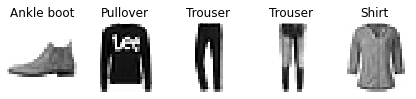

In [64]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()